In [4]:
#回帰モデル
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

#ead the data frame 
csv_house = pd.read_csv('../dataset/house_train.csv')
# no Nan values
print(csv_house.isnull().sum())

#check the data , change renovation year to a 0~10pt scale
csv_house.head()

del(csv_house['id'])

id              0
price           0
bedrooms        0
bathrooms       0
sqft_living     0
sqft_lot        0
floors          0
waterfront      0
view            0
condition       0
grade           0
yr_built        0
yr_renovated    0
dtype: int64


In [5]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

max_renovated = np.max(csv_house['yr_renovated'])
for i in range(1,11):
    # get 10 categories  with lenght  5*i
    renovated_value = max_renovated-5*i
    #to each category give value 10-i
    csv_house['yr_renovated'][csv_house['yr_renovated']> renovated_value] = 10-i
    print(renovated_value)
    
csv_house['yr_renovated'][csv_house['yr_renovated'] > 1900] = 0



2010
2005
2000
1995
1990
1985
1980
1975
1970
1965


In [6]:

def normalize(x):
    xmean =  x.mean()
    xstd  =  np.std(x)
    print('平均{},標準差は{}です'.format(xmean, xstd))
    zscore = (x - xmean)/xstd
    return zscore
#set the hyperparameters
rgs = Lasso(normalize = True)
#説明変数を格納する　勝手に正規化してくれる
X_house = csv_house.iloc[:,1:]
#目的変数を格納
Y_house = normalize(csv_house.iloc[:,0])
# set the parameters 
params = {'alpha': [0, 0.0001, 0.001, 0.01], 'random_state':[0]}
# look for the best parameters set　　
#　algorithm chooses the highest value, hence for mse values  multiply by -1 to get the same trend

gs_house = GridSearchCV(rgs, params, cv=20, n_jobs =-1, scoring='neg_mean_squared_error' )
# fit
gs_house.fit(X_house, Y_house)
print('計算完了')


平均532513.9753333334,標準差は366713.52174078795です
計算完了


In [7]:
#2乗したデータまでを格納
quadratic = PolynomialFeatures(degree = 2)
X_quadratic_house = quadratic.fit_transform(X_house)
params4 = {'alpha':[0,  0.00001, 0.0001, 0.001 ], 'random_state':[0] }
gs_house2 = GridSearchCV(rgs, params4, cv = 10, n_jobs=-1, scoring='neg_mean_squared_error')
gs_house2.fit(X_quadratic_house, Y_house)



GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=True, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0, 1e-05, 0.0001, 0.001],
                         'random_state': [0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [8]:
#テスト用データを用いた精度予測

#データごとに平均値、標準偏差がなかったらまずいので、定数を与える
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
def normalize_test(x):
    #use the mean from  Y_house (price)
    xmean = 532513.975
    xstd = 366713.522
    zscore = (x-xmean)/xstd
    return zscore

csv_house_test = pd.read_csv('../dataset/house_test.csv')
#最新年数は2015
max_renovated = 2015
#yr_renovatedの前処理
for i in range(1,11):
    renovated_value =  max_renovated - 5*i
    csv_house_test['yr_renovated'][csv_house_test['yr_renovated']>renovated_value] = 10-i
    print(renovated_value)
csv_house_test['yr_renovated'][csv_house_test['yr_renovated']>1900] = 0
# Delete id column
del(csv_house_test['id'])
X_house_test = csv_house_test.iloc[:,1:]
#テスト用データの目的変数を格納する
Y_house_ans = normalize_test(csv_house_test.iloc[:,0])

2010
2005
2000
1995
1990
1985
1980
1975
1970
1965


In [9]:
#与えられたデータを2乗に拡張する
quadratic_test = PolynomialFeatures(degree=2)
X_quadratic_house_test = quadratic_test.fit_transform(X_house_test)
#学習済みモデル(線形モデル)を用いて値を予測.
house_pred1= gs_house.predict(X_house_test)
#学習済みモデル(多項式回帰モデル)を用いて値を予測. 

house_pred2 = gs_house2.predict(X_quadratic_house_test)


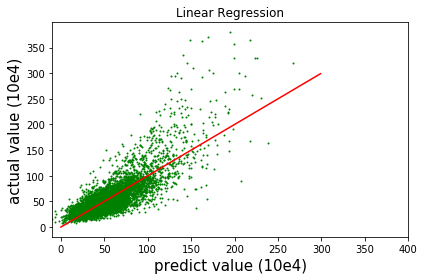

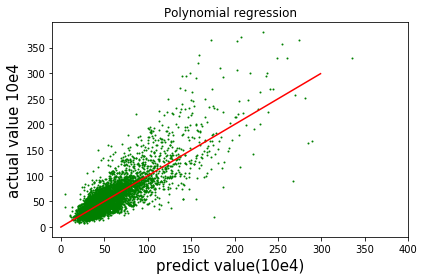

In [10]:
#実際に可視化、xMEANとＳＴＤを用いて価格に復元する
xmean = 532513.975
xstd = 366713.522
#軸がみにくいので10000で割る
house_pred1_actual = (xstd* house_pred1+xmean)/1e4
house_pred2_actual = (xstd*house_pred2+xmean)/1e4
house_ans_actual = (xstd*Y_house_ans+xmean)/1e4

#線形回帰の予測値と実際値の比較
plt.scatter(house_pred1_actual, house_ans_actual, c='g', s=1)
plt.plot(range(300),range(300), c='r')# y = x
plt.xlabel('predict value (10e4)', size=15)
plt.ylabel('actual value (10e4)', size = 15)
plt.title('Linear Regression')
plt.xlim(-10,400)
plt.tight_layout()
plt.show()

#多項式回帰の予測値と実際の値の比較
plt.scatter(house_pred2_actual, house_ans_actual, c='g',s=1)
plt.plot(range(300),range(300), c = 'r')
plt.xlabel('predict value(10e4)', size = 15)
plt.ylabel('actual value 10e4', size = 15)
plt.title('Polynomial regression')
plt.xlim(-10,400)
plt.tight_layout()
plt.show()